# MIE1516 Final Project: A Specific Pedestrian Attribute Detection by Multiple Models

## Part A: Preperation

### Packages Preperation 

In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import cv2
from os import listdir
from os.path import join
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pylab as plt
import tensorflow as tf
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score,accuracy_score
from sklearn.metrics import precision_score,f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from scipy import interp
from itertools import cycle

from keras import models, layers, optimizers
from keras import Sequential
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from keras.utils.vis_utils import plot_model

### Data and Labels Preperation

In [0]:
!unzip -uq "/content/drive/My Drive/MIE1516/PETA.zip" -d PETA

In [0]:
#set image path
mypath = 'PETA/PETA dataset/CUHK/archive/'
files = listdir(mypath)

#Remove Label.txt filename
files.remove('Label.txt')
files.sort()

#### Import the original labels

In [0]:
#Create raw label
col = ['id','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r']
raw_label = pd.read_csv('PETA/PETA dataset/CUHK/archive/Label.txt', names = col, delim_whitespace=True)

In [0]:
raw_label = raw_label.sort_values(by='id')
#Since we are missing 0000.png and 0001.png in the dataset
raw_label = raw_label.drop(raw_label.index[[0,1]])
raw_label = raw_label.reset_index(drop=True)

In [9]:
raw_label.head()

,id,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r
0,0002.png,upperBodyBlack,upperBodyGrey,upperBodyOrange,lowerBodyPurple,hairBlack,footwearBlack,footwearWhite,lowerBodyCasual,lowerBodyTrousers,personalLess45,personalMale,upperBodyCasual,upperBodyLongSleeve,upperBodyOther,hairShort,footwearSneakers,carryingNothing,accessoryNothing
1,0003.png,upperBodyBlack,upperBodyGrey,lowerBodyBlack,hairBlack,footwearGrey,lowerBodyCasual,lowerBodyTrousers,personalLess60,personalMale,upperBodyCasual,upperBodyLongSleeve,upperBodyOther,hairShort,footwearShoes,carryingLuggageCase,accessoryNothing,NaN,NaN
2,0004.png,upperBodyBrown,lowerBodyBlack,hairBlack,footwearBlack,footwearWhite,lowerBodyCasual,lowerBodyTrousers,personalLess30,personalMale,upperBodyCasual,upperBodyLongSleeve,upperBodyOther,hairShort,footwearSneakers,carryingBackpack,accessoryNothing,NaN,NaN
3,0005.png,upperBodyGrey,upperBodyPink,upperBodyWhite,lowerBodyGrey,hairBlack,footwearBlack,lowerBodyCasual,lowerBodyShortSkirt,personalFemale,personalLess30,upperBodyCasual,upperBodyLongSleeve,upperBodyOther,hairLong,footwearBoots,footwearStocking,carryingMessengerBag,accessoryNothing
4,0006.png,upperBodyBlack,upperBodyGrey,lowerBodyGrey,hairBlack,footwearWhite,lowerBodyCasual,lowerBodyTrousers,personalLess30,personalMale,upperBodyCasual,upperBodyLongSleeve,upperBodyOther,hairShort,footwearSneakers,carryingBackpack,accessoryNothing,NaN,NaN


### Assistant Function

In [0]:
#Imported from Assignment 4
def print_confusion_matrix(confusion_matrix, class_names, 
                           figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [0]:
#Imported from CNN Lab
def show_data(generator, sample_size=5):
    image,_ = train_generator.next()
    plt.figure(figsize=(16, 8))
    reference = image[:sample_size]
    for i in range(reference.shape[0]):
        plt.subplot(int(reference.shape[0]/sample_size)+1, sample_size, i+1)
        plt.imshow(reference[i])
    plt.show()

In [0]:
#Imported from the Cifar_10 Lab
def random_examples(image, label, predict, Label_names, sample_size=5):
    plt.figure(figsize=(18, 10))
    reference = image[:sample_size]
    for i in range(reference.shape[0]):
        plt.subplot(int(reference.shape[0]/sample_size)+1, 
                    sample_size, i+1)
        plt.imshow(reference[i])
        plt.xlabel('label:{0}\n pred:{1}'.format(Label_names[label[i]],
                                                 Label_names[pred[i]]), 
                   fontsize=13)
    plt.show()

## Part B: Carrying Attribute

#### List out all carrying attributes

In [0]:
#Create a list of 'carrying' attributes
all_carrying_attributes = ['id', 
 'carryingBabyBuggy',
 'carryingBackpack',
 'carryingFolder',
 'carryingLuggageCase',
 'carryingMessengerBag',
 'carryingPlasticBags',
 'carryingSuitcase',
 'carryingUmbrella',
 'carryingOther',
 'carryingNothing',]

In [0]:
#Create a DataFrame with only carrying attributes
carrying_labels = pd.DataFrame(columns = all_carrying_attributes)
carrying_labels['id'] = files
carrying_labels = carrying_labels.sort_values(by='id')

In [0]:
#Remove 'id' from all_carrying_attributes list
all_carrying_attributes.remove('id')

In [0]:
#Fill out the carrying_labels DataFrame with 1(yes) and 0(no)
for index, row in raw_label.iterrows():
    for item in row:
        if item in all_carrying_attributes:
            carrying_labels.iloc[index][item]=1 
carrying_labels=carrying_labels.fillna(0)

In [43]:
carrying_labels.head()

,id,carryingBabyBuggy,carryingBackpack,carryingFolder,carryingLuggageCase,carryingMessengerBag,carryingPlasticBags,carryingSuitcase,carryingUmbrella,carryingOther,carryingNothing
0,0002.png,0,0,0,0,0,0,0,0,0,1
1,0003.png,0,0,0,1,0,0,0,0,0,0
2,0004.png,0,1,0,0,0,0,0,0,0,0
3,0005.png,0,0,0,0,1,0,0,0,0,0
4,0006.png,0,1,0,0,0,0,0,0,0,0


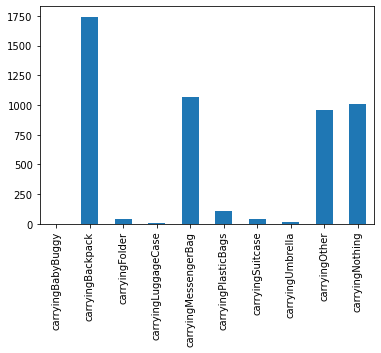

In [44]:
#Show distribution of dataset
carrying_labels.sum(axis=0, numeric_only=True).plot(kind='bar')

As we can see from the above Chart, the dataset is very imbalanced because 'carryingPlasticBags', 'carryingFolder', 'carryingLuggageCase' have too less samples but other categories have at least 1000 samples. Therefore, I would categorize these three categories as 'carryingOther'. 


In [0]:
#Create a list of imbalanced categories
imbalanced_carrying_att = ['carryingBabyBuggy','carryingPlasticBags', 'carryingFolder', 'carryingLuggageCase', 'carryingSuitcase', 'carryingUmbrella']

In [0]:
#Create a new DataFrame
balanced_carrying_labels = carrying_labels

In [47]:
#Categorize all imbalanced attributes to 'carryingOther'
for att in imbalanced_carrying_att:
    for i in range(len(balanced_carrying_labels)):
        if balanced_carrying_labels[att][i] == 1:
           balanced_carrying_labels['carryingOther'][i] = 1
balanced_carrying_labels =  balanced_carrying_labels.drop(imbalanced_carrying_att, axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [48]:
balanced_carrying_labels.head()

,id,carryingBackpack,carryingMessengerBag,carryingOther,carryingNothing
0,0002.png,0,0,0,1
1,0003.png,0,0,1,0
2,0004.png,1,0,0,0
3,0005.png,0,1,0,0
4,0006.png,1,0,0,0


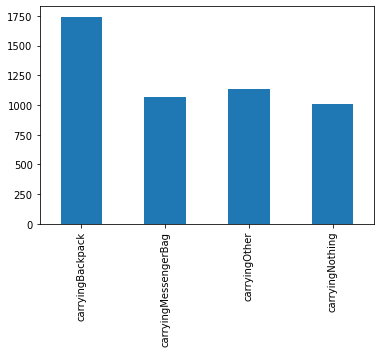

In [49]:
#Show distribution of a balanced dataset
balanced_carrying_labels.sum(axis=0, numeric_only=True).plot(kind='bar')

### Data seperation to train and validation data

In [0]:
main_carrying_attributes = ['carryingMessengerBag','carryingBackpack','carryingOther','carryingNothing']

In [0]:
height=160
width=80
batch_size=32
seed=1337


# Training generator
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2,
        rotation_range=20,
		zoom_range=0.4,
        shear_range=0.5,
		horizontal_flip=True)

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
          directory=mypath,
          dataframe=balanced_carrying_labels[:4107],
          x_col='id',
          y_col=main_carrying_attributes,
          target_size=(height,width),
          batch_size=batch_size,
          seed=seed,
          shuffle=True,
          class_mode='raw',
          subset='training')

valid_generator = train_datagen.flow_from_dataframe(
          directory=mypath, 
          dataframe=balanced_carrying_labels[:4107],
          x_col='id',
          y_col=main_carrying_attributes,
          target_size=(height,width),
          batch_size=batch_size,
          seed=seed,
          shuffle=True,
          class_mode='raw',
          subset='validation')

test_generator = test_datagen.flow_from_dataframe(
          directory=mypath, 
          dataframe=balanced_carrying_labels[4107:],
          x_col='id',
          y_col=main_carrying_attributes,
          target_size=(height,width),
          batch_size=batch_size,
          seed=seed,
          shuffle=True,
          class_mode='raw')

Found 3286 validated image filenames.
Found 821 validated image filenames.
Found 456 validated image filenames.


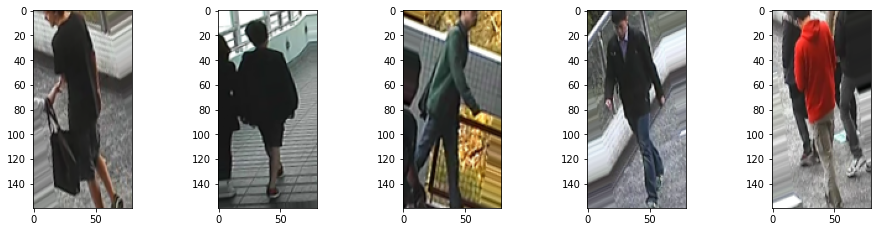

In [0]:
show_data(train_generator)

In [28]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
print('Training step size is {} and Valid step size is {}'.format(STEP_SIZE_TRAIN, STEP_SIZE_VALID))

Training step size is 102 and Valid step size is 25


### Baseline Model with VGG-19

In [0]:
#Imported from CNN Lab
channels=3

# Initialize the base model
base_model = VGG19(weights='imagenet',
                   include_top=False,
                   input_shape=(height, width, channels))

# Fine-tuning layers
x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x) 
model = Model(inputs=base_model.input, outputs=predictions)

# Set base_model nontrainable
for layer in base_model.layers:
    layer.trainable = False

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit_generator(generator=train_generator, 
                steps_per_epoch=STEP_SIZE_TRAIN,
                validation_data=valid_generator, 
                validation_steps=STEP_SIZE_VALID,
                epochs=10)

Epoch 1/10
102/102 [==============================] - 16s 156ms/step - loss: 1.5053 - acc: 0.3422 - val_loss: 1.4919 - val_acc: 0.3887
Epoch 2/10
102/102 [==============================] - 16s 160ms/step - loss: 1.4379 - acc: 0.3775 - val_loss: 1.6624 - val_acc: 0.2497
Epoch 3/10
102/102 [==============================] - 16s 157ms/step - loss: 1.4393 - acc: 0.3812 - val_loss: 1.5878 - val_acc: 0.3574
Epoch 4/10
102/102 [==============================] - 16s 158ms/step - loss: 1.4261 - acc: 0.3794 - val_loss: 1.4634 - val_acc: 0.3954
Epoch 5/10
102/102 [==============================] - 16s 154ms/step - loss: 1.4176 - acc: 0.4032 - val_loss: 1.6451 - val_acc: 0.2586
Epoch 6/10
102/102 [==============================] - 15s 150ms/step - loss: 1.4191 - acc: 0.3900 - val_loss: 1.4881 - val_acc: 0.3207
Epoch 7/10
102/102 [==============================] - 15s 151ms/step - loss: 1.4040 - acc: 0.4034 - val_loss: 1.5623 - val_acc: 0.2852
Epoch 8/10
102/102 [==============================] - 1

In [0]:
Y_pred = np.argmax(model.predict_generator(test_generator), axis=1)
Y_valid = np.argmax(test_generator.labels, axis=1)

In [0]:
from sklearn import metrics
print(metrics.classification_report(Y_valid, Y_pred, target_names=main_carrying_attributes))

                      precision    recall  f1-score   support

carryingMessengerBag       0.25      0.17      0.20       100
    carryingBackpack       0.42      0.23      0.30       194
       carryingOther       0.22      0.57      0.32       104
     carryingNothing       0.18      0.05      0.08        58

            accuracy                           0.27       456
           macro avg       0.27      0.26      0.23       456
        weighted avg       0.31      0.27      0.25       456



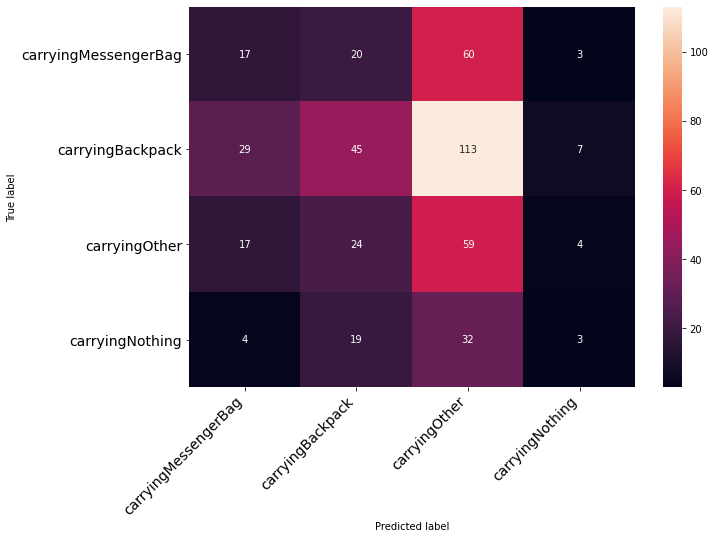

In [0]:
print_confusion_matrix(confusion_matrix(Y_valid, Y_pred), main_carrying_attributes)

### Baseline model with sigmoid+binary cross entropy loss

In [0]:
#Imported from CNN Lab
channels=3

# Initialize the base model
base_model = VGG19(weights='imagenet',
                   include_top=False,
                   input_shape=(height, width, channels))

# Fine-tuning layers
x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='sigmoid')(x) 
model = Model(inputs=base_model.input, outputs=predictions)

# Set base_model nontrainable
for layer in base_model.layers:
    layer.trainable = False

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit_generator(generator=train_generator, 
                steps_per_epoch=STEP_SIZE_TRAIN,
                validation_data=valid_generator, 
                validation_steps=STEP_SIZE_VALID,
                epochs=10)



Epoch 1/10
102/102 [==============================] - 19s 183ms/step - loss: 0.5809 - acc: 0.7276 - val_loss: 0.6097 - val_acc: 0.7219
Epoch 2/10
102/102 [==============================] - 14s 135ms/step - loss: 0.5665 - acc: 0.7311 - val_loss: 0.5916 - val_acc: 0.7215
Epoch 3/10
102/102 [==============================] - 13s 132ms/step - loss: 0.5653 - acc: 0.7300 - val_loss: 0.5867 - val_acc: 0.7202
Epoch 4/10
102/102 [==============================] - 13s 130ms/step - loss: 0.5587 - acc: 0.7321 - val_loss: 0.5658 - val_acc: 0.7231
Epoch 5/10
102/102 [==============================] - 13s 129ms/step - loss: 0.5598 - acc: 0.7308 - val_loss: 0.5659 - val_acc: 0.7228
Epoch 6/10
102/102 [==============================] - 13s 128ms/step - loss: 0.5569 - acc: 0.7336 - val_loss: 0.5839 - val_acc: 0.7218
Epoch 7/10
102/102 [==============================] - 13s 128ms/step - loss: 0.5532 - acc: 0.7317 - val_loss: 0.5794 - val_acc: 0.7189
Epoch 8/10
102/102 [==============================] -

In [0]:
y_pred = model.predict_generator(test_generator)
y_valid = test_generator.labels

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


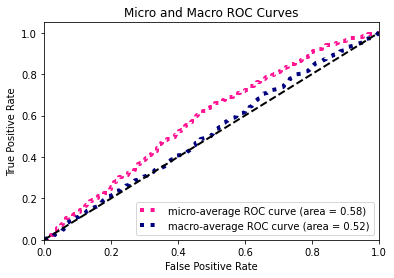

In [0]:
# Compute Microaverage and Macroaverage ROC curve&AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(main_carrying_attributes)):
    fpr[i], tpr[i], _ = roc_curve(y_valid[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute Microaverage ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_valid.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Compute Macroaverage ROC curve and AUC

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(main_carrying_attributes))]))

# Then interpolate all ROC curves
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(main_carrying_attributes)):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(main_carrying_attributes)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro and Macro ROC Curves')
plt.legend(loc="lower right")
plt.show()

In [0]:
Y_pred = np.argmax(model.predict_generator(test_generator), axis=1)
Y_valid = np.argmax(test_generator.labels, axis=1)

In [0]:
from sklearn import metrics
print(metrics.classification_report(Y_valid, Y_pred, target_names=main_carrying_attributes))

                      precision    recall  f1-score   support

carryingMessengerBag       0.23      0.40      0.29       100
    carryingBackpack       0.45      0.60      0.51       194
       carryingOther       0.12      0.01      0.02       104
     carryingNothing       0.14      0.03      0.06        58

            accuracy                           0.35       456
           macro avg       0.24      0.26      0.22       456
        weighted avg       0.29      0.35      0.29       456



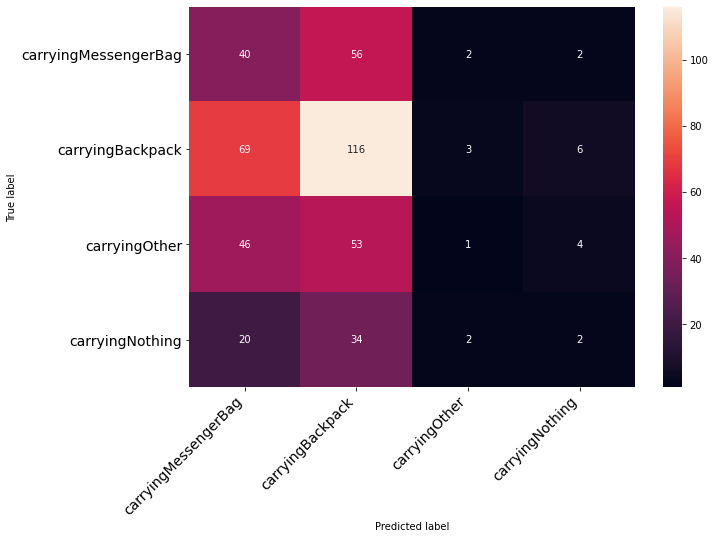

In [0]:
print_confusion_matrix(confusion_matrix(Y_valid, Y_pred), main_carrying_attributes)

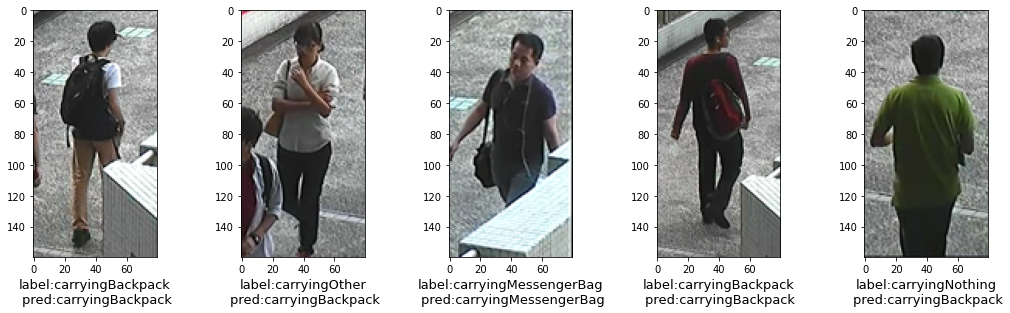

In [0]:
image,label = test_generator.next()
label = np.argmax(label, axis=1)
pred = np.argmax(model.predict(image), axis=1)
random_examples(image,label, pred, main_carrying_attributes)

## Part C: Full attributes

#### List all unique attributes

In [0]:
unique_attribute = []
#Append all unique attributes to one list
for index, row in raw_label.drop(['id'],axis=1).iterrows():
    for item in row:
        if item not in unique_attribute:
            unique_attribute.append(item)

In [0]:
#Drop all sample names
unique_attribute = [item for item in unique_attribute if type(item)!= float]

In [0]:
#Sort the list
unique_attribute.sort()

In [15]:
unique_attribute

['accessoryFaceMask',
 'accessoryHairBand',
 'accessoryHat',
 'accessoryHeadphone',
 'accessoryKerchief',
 'accessoryMuffler',
 'accessoryNothing',
 'accessoryShawl',
 'accessorySunglasses',
 'carryingBabyBuggy',
 'carryingBackpack',
 'carryingFolder',
 'carryingLuggageCase',
 'carryingMessengerBag',
 'carryingNothing',
 'carryingOther',
 'carryingPlasticBags',
 'carryingSuitcase',
 'carryingUmbrella',
 'footwearBlack',
 'footwearBlue',
 'footwearBoots',
 'footwearBrown',
 'footwearGreen',
 'footwearGrey',
 'footwearLeatherShoes',
 'footwearOrange',
 'footwearPink',
 'footwearPurple',
 'footwearRed',
 'footwearSandals',
 'footwearShoes',
 'footwearSneakers',
 'footwearStocking',
 'footwearWhite',
 'footwearYellow',
 'hairBald',
 'hairBlack',
 'hairBrown',
 'hairGrey',
 'hairLong',
 'hairPurple',
 'hairShort',
 'hairWhite',
 'lowerBodyBlack',
 'lowerBodyBlue',
 'lowerBodyBrown',
 'lowerBodyCapri',
 'lowerBodyCasual',
 'lowerBodyFormal',
 'lowerBodyGreen',
 'lowerBodyGrey',
 'lowerBodyHo

In [16]:
print('There are {} unique attributes'.format(len(unique_attribute)))

There are 101 unique attributes


### Label each image with the complete attribute list

In [0]:
#Add 'id' column at the beginning
unique_attribute.insert(0, 'id')

In [0]:
#Crete a Dataframe with each attribute as a column
full_labels = pd.DataFrame(columns = unique_attribute)
full_labels['id'] = files
full_labels = full_labels.sort_values(by='id')

In [0]:
#Remove 'id' in the list
unique_attribute.remove('id')

In [0]:
#Fill out the DataFrame with 1 and 0 for each attribute
for index, row in raw_label.iterrows():
    for item in row:
        if item in unique_attribute:
            full_labels.iloc[index][item]=1 
full_labels=full_labels.fillna(0)

In [0]:
#Drop columns that have less than 100 samples
for column in full_labels.columns[1:]:
    if full_labels[column].sum(axis=0) < 100:
        full_labels = full_labels.drop(columns=column)

In [22]:
full_labels.head()

,id,accessoryHairBand,accessoryNothing,carryingBackpack,carryingMessengerBag,carryingNothing,carryingOther,carryingPlasticBags,footwearBlack,footwearBoots,footwearBrown,footwearGrey,footwearLeatherShoes,footwearRed,footwearShoes,footwearSneakers,footwearStocking,footwearWhite,hairBlack,hairLong,hairShort,lowerBodyBlack,lowerBodyBlue,lowerBodyBrown,lowerBodyCasual,lowerBodyFormal,lowerBodyGrey,lowerBodyJeans,lowerBodyShortSkirt,lowerBodyShorts,lowerBodyTrousers,personalFemale,personalLess30,personalLess45,personalLess60,personalMale,upperBodyBlack,upperBodyBlue,upperBodyBrown,upperBodyCasual,upperBodyFormal,upperBodyGreen,upperBodyGrey,upperBodyJacket,upperBodyLogo,upperBodyLongSleeve,upperBodyOther,upperBodyPlaid,upperBodyPurple,upperBodyRed,upperBodyShortSleeve,upperBodyThinStripes,upperBodyTshirt,upperBodyWhite
0,0002.png,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0
1,0003.png,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0
2,0004.png,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0
3,0005.png,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,1
4,0006.png,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0


In [23]:
len(full_labels.columns)

54

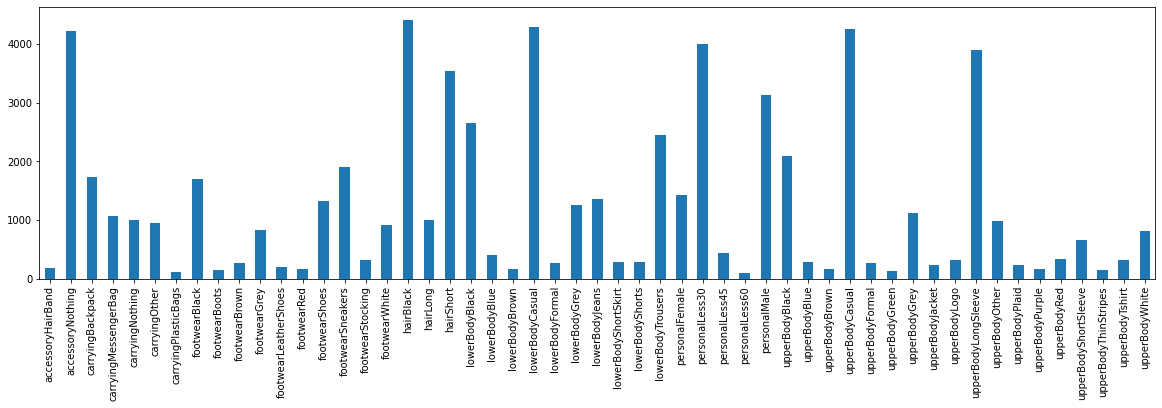

In [24]:
#Show the distribution of all attributes
full_labels.sum(axis=0, numeric_only=True).plot(kind='bar', figsize=(20,5))

### Data seperation to train and validation data

In [60]:
height=160
width=80
batch_size=32
seed=1337


# Training generator
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2,
        rotation_range=20,
		zoom_range=0.1,
        shear_range=0.5,
		horizontal_flip=True)

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
          directory=mypath,
          dataframe=full_labels[:4107],
          x_col='id',
          y_col=full_labels.columns[1:],
          target_size=(height,width),
          batch_size=batch_size,
          seed=seed,
          shuffle=True,
          class_mode='raw',
          subset='training')

valid_generator = train_datagen.flow_from_dataframe(
          directory=mypath, 
          dataframe=full_labels[:4107],
          x_col='id',
          y_col=full_labels.columns[1:],
          target_size=(height,width),
          batch_size=batch_size,
          seed=seed,
          shuffle=True,
          class_mode='raw',
          subset='validation')

test_generator = test_datagen.flow_from_dataframe(
          directory=mypath, 
          dataframe=full_labels[4107:],
          x_col='id',
          y_col=full_labels.columns[1:],
          target_size=(height,width),
          batch_size=batch_size,
          seed=seed,
          shuffle=True,
          class_mode='raw')

Found 3286 validated image filenames.
Found 821 validated image filenames.
Found 456 validated image filenames.


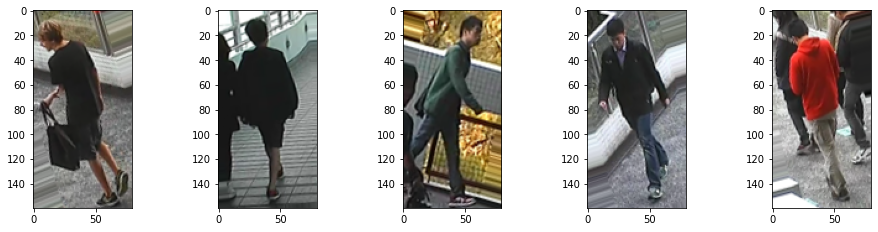

In [61]:
show_data(train_generator, sample_size=5)

### Training Model with by sigmoid+cross entropy loss

In [0]:
#Imported from CNN Lab
channels=3

# Initialize the base model
base_model = VGG19(weights='imagenet',
                   include_top=False,
                   input_shape=(height, width, channels))

# Fine-tuning layers
x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = Dense(256, activation='relu')(x)
predictions = Dense(len(full_labels.columns)-1, activation='sigmoid')(x) 
model = Model(inputs=base_model.input, outputs=predictions)

# Set base_model nontrainable
for layer in base_model.layers:
    layer.trainable = False

In [93]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit_generator(generator=train_generator, 
                steps_per_epoch=STEP_SIZE_TRAIN,
                validation_data=valid_generator, 
                validation_steps=STEP_SIZE_VALID,
                epochs=50)

Epoch 1/50
102/102 [==============================] - 13s 127ms/step - loss: 0.3299 - acc: 0.8613 - val_loss: 0.3717 - val_acc: 0.8716
Epoch 2/50
102/102 [==============================] - 13s 131ms/step - loss: 0.3273 - acc: 0.8614 - val_loss: 0.3008 - val_acc: 0.8714
Epoch 3/50
102/102 [==============================] - 13s 131ms/step - loss: 0.3266 - acc: 0.8626 - val_loss: 0.3459 - val_acc: 0.8660
Epoch 4/50
102/102 [==============================] - 13s 128ms/step - loss: 0.3244 - acc: 0.8631 - val_loss: 0.2978 - val_acc: 0.8720
Epoch 5/50
102/102 [==============================] - 13s 126ms/step - loss: 0.3239 - acc: 0.8631 - val_loss: 0.3180 - val_acc: 0.8698
Epoch 6/50
102/102 [==============================] - 13s 126ms/step - loss: 0.3233 - acc: 0.8637 - val_loss: 0.3186 - val_acc: 0.8716
Epoch 7/50
102/102 [==============================] - 13s 125ms/step - loss: 0.3199 - acc: 0.8645 - val_loss: 0.3600 - val_acc: 0.8660
Epoch 8/50
102/102 [==============================] - 1

In [0]:
y_pred = model.predict_generator(test_generator)
y_valid = test_generator.labels

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


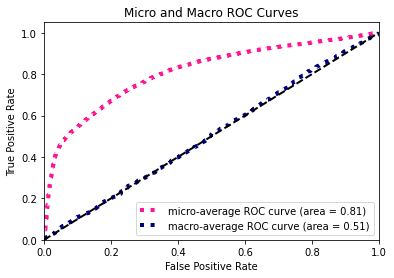

In [95]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(full_labels.columns)-1):
    fpr[i], tpr[i], _ = roc_curve(y_valid[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_valid.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(full_labels.columns)-1)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(full_labels.columns)-1):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= (len(full_labels.columns)-1)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro and Macro ROC Curves')
plt.legend(loc="lower right")
plt.show()
